In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import re
from os.path import join, basename, dirname
from glob import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from natsort import natsorted
import torch

from torchvision.io import read_image
from torchvision.utils import make_grid
from torchvision import transforms

from gradcam.utils import visualize_cam
from gradcam import GradCAM, GradCAMpp

In [3]:
from experiment_utils import set_env, REPO_PATH, seed_everything
set_env()

In [4]:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Computer Modern Roman"],
})

### Helpers

In [5]:
def denormalize(x: torch.Tensor, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    """Denormalizes an image."""

    mean = np.array(mean)
    std = np.array(std)
    denormalize = transforms.Normalize(
        mean=-(mean / std),
        std=(1.0 / std),
    )

    return denormalize(x)

In [6]:
def show_single_image(x: torch.Tensor, normalized=True, title="Sample image"):
    """Displays a single image."""

    assert len(x.shape) == 3
    
    if normalized:
        x = denormalize(x)
    
    if x.shape[0] == 3:
        x = x.permute((1, 2, 0))

    plt.imshow(x)
    plt.title(title)
    plt.xticks([])
    plt.yticks([])
    plt.show()

### Set environment

In [7]:
seed_everything(0)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### Load `ImageNet` dataset

In [8]:
from imagenet.dataloader import get_imagenet_dls

In [9]:
train_loader, val_loader, train_sampler = get_imagenet_dls(
    "imagenet/data/in-mini", False, 64, 10,
)

In [10]:
len(train_loader), len(val_loader)

(543, 62)

In [11]:
ds_val = val_loader.dataset

In [12]:
# check out a sample
index = 0
sample = ds_val[index]

In [13]:
sample["ims"].shape, sample["ims"].min(), sample["ims"].max(), sample["labels"]

(torch.Size([3, 224, 224]), tensor(-2.0837), tensor(2.6400), tensor(0))

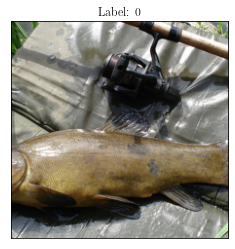

In [14]:
show_single_image(sample["ims"], title=f"Label: {sample['labels'].data}")

### Load model

In [15]:
from imagenet.models.classifier_ensemble import InvariantEnsemble

In [16]:
model = InvariantEnsemble("resnet50", pretrained=True)

In [17]:
# load weights from a checkpoint
ckpt_path = "imagenet/experiments/classifier_2022_01_19_15_36_sample_run/model_best.pth"
ckpt = torch.load(ckpt_path, map_location="cpu")
ckpt_state_dict = ckpt["state_dict"]
ckpt_state_dict = {k.replace("module.", ""):v for k, v in ckpt_state_dict.items()}

In [18]:
model.load_state_dict(ckpt_state_dict)

<All keys matched successfully>

In [19]:
model = model.eval()

In [20]:
class ShapeModel(torch.nn.Module):

    def __init__(self):
        super(ShapeModel, self).__init__()

        self.base_model = model
    
    def forward(self, x):
        x = self.base_model.backbone(x)
        x = self.base_model.m_shape(x)
        return x

In [21]:
shape_model = ShapeModel()

### Apply GradCAM on a sample image

In [22]:
# define the target layer to be used
# target_layer = model.m_shape[1]
# target_layer = shape_model.base_model.m_shape[1]

target_layer = shape_model.base_model.backbone[7][2].conv1
gradcam = GradCAM(shape_model, target_layer)

alpha = 0.7

In [23]:
# get image
sample = ds_val[index]
image, label = sample["ims"], sample["labels"]

# get gradcam mask
gc_mask, _ = gradcam(image.unsqueeze(0))
heatmap, result = visualize_cam(gc_mask, image)
gc_mask = gc_mask.squeeze(0)

# compute custom result: alpha-linear combination of image (denormalized) and heatmap
denormalized_image = denormalize(image.data.cpu())
overlap = alpha * denormalized_image + (1 - alpha) * heatmap.data.cpu()

# create a grid with original, heatmap and overlapped
grid = make_grid([denormalized_image, heatmap, overlap], nrow=3)

/home/lcur0478/.conda/envs/gcn-gpu/lib/python3.9/site-packages/torch/nn/modules/module.py:1025: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/lcur0478/.conda/envs/gcn-gpu/lib/python3.9/site-packages/torch/nn/functional.py:3509: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


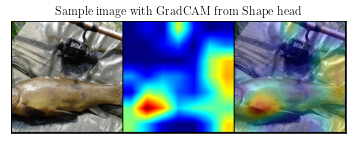

In [24]:
show_single_image(grid, normalized=False, title="Sample image with GradCAM from Shape head")